In [1]:
# open model
from simple_net import SimpleNet
import torch

model = SimpleNet(1)
model.load_state_dict(torch.load("largefc1_attempt2.pth"))
model.eval()

SimpleNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3),

In [2]:
# open test dataset
from dataset import PneumoniaDataset, SetType
test_set = PneumoniaDataset(SetType.test, shuffle=False)
len(test_set)

624

In [3]:
import numpy as np
from tqdm import tqdm

def predict(model_output):
    sigmoid = torch.nn.Sigmoid()
    return sigmoid(model_output).item()

def threshold(prediction):
   # if prediction > .5, return 1, else 0
    return np.round(prediction)
    #return 1.0 if prediction > 0.89 else 0.0

results = {"labels": [], "raw_preds": [], "rounded_preds": [], "metadata": []}

for img, label, metadata in tqdm(test_set):
    with torch.no_grad():
        results["labels"].append(label)
        pred = model(img.unsqueeze(0))
        pred = predict(pred.detach())
        results["raw_preds"].append(pred)
        results["rounded_preds"].append(threshold(pred))
        results["metadata"].append(metadata)


100%|██████████| 624/624 [02:38<00:00,  3.95it/s]


In [48]:
# visualize non-rounded wrong preds and non-rounded correct preds (hists?)
#create cm / ravel / roc curves
from sklearn.metrics import confusion_matrix

def custom_threshold(pred):
    return 1.0 if pred > 0.85 else 0.0

results["custom_thresholded"] = [custom_threshold(result) for result in results["raw_preds"]]

cm = confusion_matrix(results["labels"], results["custom_thresholded"])

# need to do better than 98 false positives and 3 false negatives. (the 3 false negatives are .4, and two
# very very close to 0)

def print_stats(cmat):
    tn, fp, fn, tp = cmat.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)

    print(f"Precision:\t{precision}\tRecall:\t{recall}")
    print(f"False Negatives: {fn}")
    print(f"False Positives: {fp}")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f'Accuracy: {(tn+tp)/len(results["labels"])}')
    print(f"F Measure: {2*((precision*recall)/(precision+recall))}")
    
print_stats(cm)

Precision:	0.8662131519274376	Recall:	0.9794871794871794
False Negatives: 8
False Positives: 59
True Positives: 382
True Negatives: 175
Accuracy: 0.8926282051282052
F Measure: 0.9193742478941036


In [24]:
import pandas as pd
# is there a better threshold than .5?
#for i, pred in enumerate(results["raw_preds"]):
#    if results["custom_thresholded"][i] != results["labels"][i]:
#        print(f'Pred: {pred}\tLabel: {results["labels"][i]}')
              
false_positives = [y for i, y in enumerate(results["raw_preds"]) if
                   results["custom_thresholded"][i] != results["labels"][i] and results["labels"][i] == 0]
              
false_negatives = [y for i, y in enumerate(results["raw_preds"]) if
                   results["custom_thresholded"][i] != results["labels"][i] and results["labels"][i] == 1]
df = pd.DataFrame(false_positives)
df.describe()

,0
count,59.000000
mean,0.967966
std,0.040111
min,0.860156
25%,0.952376
50%,0.989055
75%,0.997718
max,0.999994


In [25]:
neg_df = pd.DataFrame(false_negatives)
neg_df.describe()

,0
count,8.000000
mean,0.460413
std,0.272663
min,0.021229
25%,0.321140
50%,0.569925
75%,0.644749
max,0.730917


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd898fdf210>]],
      dtype=object)

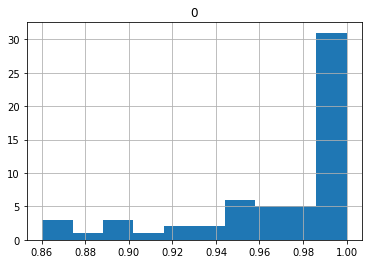

In [27]:
df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd898e5e8d0>]],
      dtype=object)

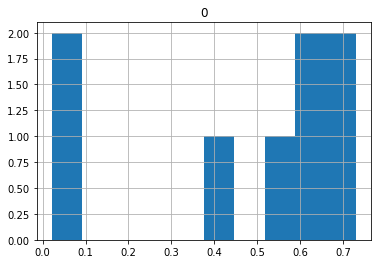

In [28]:
neg_df.hist()

In [ ]:
# The histograms show room for an 'Unsure' area between .4 and .94 in which the result
# could alert the user.

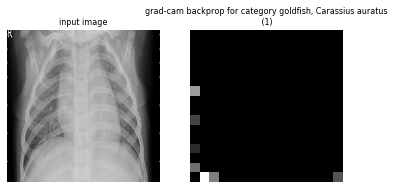

In [46]:
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
from torchray.benchmark import plot_example

# Grad-CAM backprop.
saliency_layer = get_module(model, 'conv10')

probe = Probe(saliency_layer, target='output')

y = model(test_set[21][0].unsqueeze(0))
y.backward()

saliency = gradient_to_grad_cam_saliency(probe.data[0])

# Plots.
plot_example(test_set[21][0].unsqueeze(0), saliency, 'grad-cam backprop', 1, 0)